# Альтернативный подход к построению модели

Пердполагяется определиться заранее и идентификационной формой и пытаться улучшать её всеми доступными методами

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score

import torch.optim as optim

import matplotlib.pyplot as plt

from nets_algo import *
from model_train import model_trainer

# Подготовительный этап

## Функция потерь

In [2]:
loss_fn = nn.BCELoss()

## Данные

In [59]:
data = pd.read_csv(
    "/home/dranik/KFA/university/proc_2.csv", 
    index_col = 0
)

Y = np.array(data[['Y']])
X = data.drop('Y', axis = 1)

X = np.concatenate([
    OneHotEncoder(sparse = False).\
    fit_transform(X.loc[:,X.dtypes == "O"]),
    X.loc[:,X.dtypes != "O"].to_numpy()
], axis = 1)

# номализация
X = normalize(X)

# для того, чтобы при тестировании подтянуть, 
# например, процентные стваки, нам нужно сохранить индекс
# чтобы до него можно было добраться при валидации
X = np.concatenate([X, np.expand_dims(data.index.to_numpy(),axis = 1)], axis = 1)

X_train, X_test, y_train, y_test = \
    train_test_split(X,Y, random_state = 0, stratify = Y)

#Сохраним полученные наборы данных - пригодяться при валидации. 
#И удалим индекс - он не нужен при обучении модели.

save_path = '/home/dranik/KFA/university/training_valid_data'
np.save(save_path + "/X_train", X_train)
np.save(save_path + "/y_train", y_train)
np.save(save_path + "/X_test", X_test)
np.save(save_path + "/y_test", y_test)

# удаление из test/train подследней строчки - индекса
X_train, X_test = (np.delete(X, -1, axis = 1) for X in [X_train, X_test])

Наборы данных и загрузчики данных

In [43]:
train_data = My_data_set(
    torch.tensor(X_train.astype('float32')), 
    torch.tensor(y_train.astype('float32'))
)
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=500
)

In [45]:
test_data = My_data_set(
    torch.tensor(X_test.astype('float32')), 
    torch.tensor(y_test.astype('float32'))
)
test_data_loader =\
torch.utils.data.DataLoader(
    test_data, batch_size=500
)

## Метод быстрого сохранения визуализаци результата

In [46]:
def plot_learning_curve(
    lc_data, start_show = 0, last_spes_show = 20
):
    '''Алгоритм обучения нейронной сети'''
    # inputs:
    # lc_data - собранная информация о обучении модели
    # start_show - та эпоха с которой следует начинать обучать
    # last_spes_show - та эпоха c конца с которой следует
    #                  начать отображение в правое окно
    
    plt.subplot(121)
    X_range = range(start_show, len(lc_data))

    plt.plot(X_range, lc_data[list(X_range)])
    plt.xlabel("Эпоха", fontsize = 14)
    plt.ylabel("Целевая функция", fontsize = 14)
    
    
    plt.subplot(122)
    X_range = range(
        len(lc_data)-last_spes_show, len(lc_data)
    )
    plt.plot(
        X_range, lc_data[list(X_range)]
    )
    plt.xlabel("Эпоха", fontsize = 14)

def save_my_lc(
    trainer, curve_param = {},
    plot_name = "last_plot"
):
    fig = plt.figure(figsize = [15, 6])
    
    
    plot_learning_curve(
        np.array(trainer.test_loss), 
        **curve_param
    )
    plot_learning_curve(
        np.array(trainer.train_loss),
        **curve_param
    )
    
    fig.legend([
        'тестовая выборка',
        'тренировочная выборка'
    ], fontsize = "14")
    
    plt.savefig("alt_results/" + plot_name + '.png')

## Получение AUC на train/test

In [47]:
def get_auc(model):
    
    result = {}
    
    p_hat = model(torch.tensor(X_test.astype('float32')))
    result['test'] = roc_auc_score(y_test, p_hat.detach().numpy())
    
    p_hat = model(torch.tensor(X_train.astype('float32')))
    result['train'] = roc_auc_score(y_train, p_hat.detach().numpy())
    
    return result

# Модель

## Один скрытый слой

Пример того как модель все еще продолжает оптимизацию - нужно увеличивать число эпох, так как это без каких-либо особых усилий даст нам заметный прирост производительности модели

In [51]:
torch.manual_seed(0)
model_1lay = ResultNet([X_train.shape[1], X_train.shape[1]])

optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.01
)

lay1_trainer = model_trainer(
    model_1lay, optimizer, loss_fn
)

lay1_trainer.fit(
    train_data_loader,
    test_data_loader
)

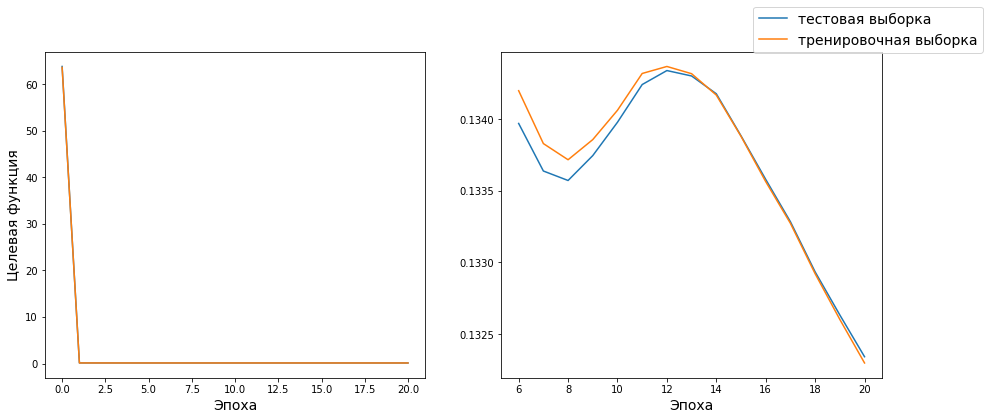

In [52]:
save_my_lc(
    lay1_trainer,
    curve_param = {'last_spes_show':15},
    plot_name = '20_epochs'
)

In [15]:
get_auc(model_1lay)

{'test': 0.7470852801719526, 'train': 0.7452849174733656}

Доучиваем модель еще на 30 эпох

In [16]:
lay1_trainer.fit(
    train_data_loader, test_data_loader, epochs = 30
)

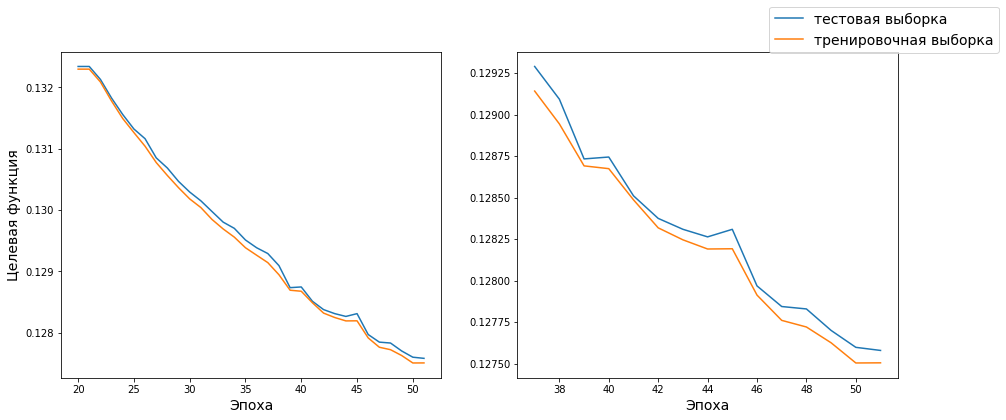

In [17]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 20, 
        'last_spes_show': 15
    },
    plot_name = '50_epochs'
)

In [18]:
get_auc(model_1lay)

{'test': 0.7753463822951931, 'train': 0.7750603319399272}

Продолжим обучение модели, но уже с меньшим learning rate

In [19]:
optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.0001
)
lay1_trainer.optimizer = optimizer

lay1_trainer.fit(
    train_data_loader, test_data_loader, epochs = 50
)

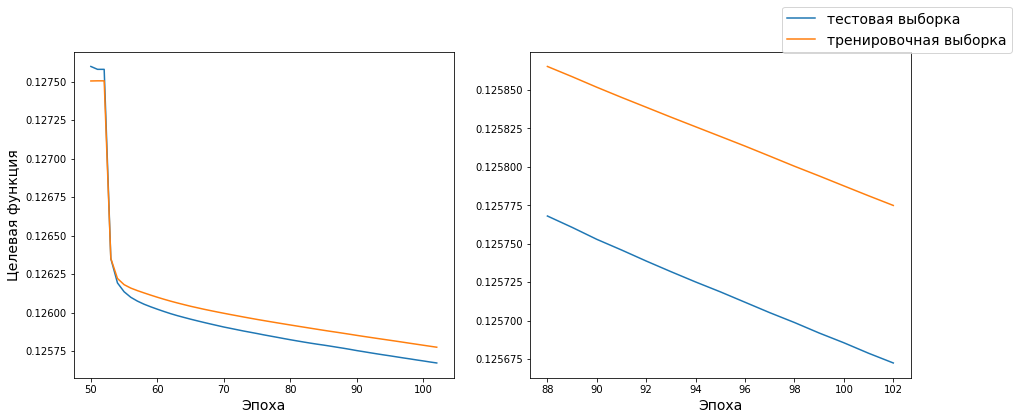

In [20]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 50, 
        'last_spes_show': 15
    },
    plot_name = '50_epochs_50_plus_lr_0.0001'
)

Тут закончим с обучением "руками" - посмотрим какой AUC был получен

In [21]:
get_auc(lay1_trainer.best_model)

{'test': 0.7803867947973121, 'train': 0.7792185632488206}

## В целом путь намечен

Учить модель до критерия остановки, понижая lr, и затем контролировать AUC.

В этот раз кроме всего прочего нам понадобиться lc_scheduler

In [2]:
torch.manual_seed(0)
model_1lay = ResultNet([X.shape[1], X.shape[1]])

optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.01
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma = 0.99,
    
)

lay1_trainer = model_trainer(
    model_1lay, optimizer, 
    loss_fn, lr_scheduler = lr_scheduler
)

lay1_trainer.fit(
    train_data_loader,
    test_data_loader,
    epochs = 1000,
    check_epoch = 20
)

NameError: name 'X' is not defined

In [3]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 50, 
        'last_spes_show': 3
    }
)

NameError: name 'save_my_lc' is not defined

In [33]:
print('эпоха лучшей модели')
print(lay1_trainer.best_epoch)
get_auc(lay1_trainer.best_model)

эпоха лучшей модели
504


{'test': 0.799774948472894, 'train': 0.8038420172204928}

## Задокументируем попытки улучшения модели

Слишком быстрое уменьшение learning rate привело к тому, что модель престала доучиваться на определнный этапах (график too_fast_lr_decr_example.png). Это дало AUC <br>
{'test': 0.7563091889685637, 'train': 0.7545147015635103}<br>
Остановка по завершению эпох (300 эпох) lr 0.99<br>
{'test': 0.7987931657804059, 'train': 0.8024815784286833}

Подсление дейсвия позволили совсем немного улучшить нейронную сеть - но в целом это тоже достижение.

# Сохранение сети

In [82]:
torch.save(
    lay1_trainer.best_model.state_dict(), 
    'model 1lay 113 neurons_after_bigfit'
)

Посмотрим, как сетка, загрузиться 

In [15]:
model = ResultNet([113, 113])
model.load_state_dict(torch.load('model 1lay 113 neurons_after_bigfit'))
get_auc(model)

{'test': 0.7997798584286935, 'train': 0.8038133171634784}

# Модель можно доучить на большем батче

In [16]:
final_tl = torch.utils.data.DataLoader(
    train_data, batch_size=X.shape[0]
)

optimizer = optim.Adam(
    model.parameters(),
    lr = 0.000001
)
lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma = 0.95,
)

lay1_trainer_improve = model_trainer(
    model, optimizer, 
    loss_fn, lr_scheduler = lr_scheduler
)

lay1_trainer_improve\
.fit(
    final_tl,
    test_data_loader,
    epochs = 100,
)

print(
    "последняя ЦФ "
    + str(lay1_trainer_improve.test_loss[-1])
)
print("лучшая эпоха " + str(lay1_trainer_improve.best_epoch))
get_auc(lay1_trainer_improve.best_model)

последняя ЦФ 0.12201997637748718
лучшая эпоха 99


{'test': 0.7997774007078017, 'train': 0.8038190565652146}

Text(0.5, 0, 'Эпоха')

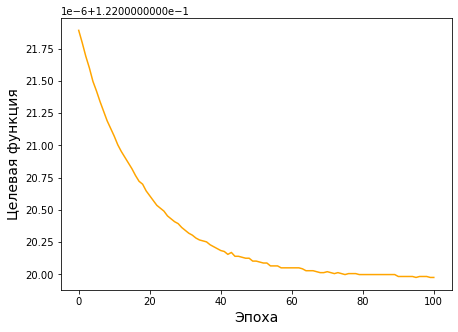

In [22]:
plt.figure(figsize = [7,5])
#plt.plot(lay1_trainer_improve.train_loss)
plt.plot(lay1_trainer_improve.test_loss, color = 'Orange')

plt.ylabel('Целевая функция', fontsize = 14)
plt.xlabel('Эпоха', fontsize = 14)